## Assignment

一：采集较暗的图像

二：平滑后缩小vs缩小后平滑效果对比

三：直方图均衡/自适应均衡效果对比

四：计算图像梯度并取梯度大于某阈值(自定)的部分覆盖原图显示

五：选定图像中任意三角形区域(自定)对比均值和中值滤波效果


## Task 1: Capture Dark Images

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0)

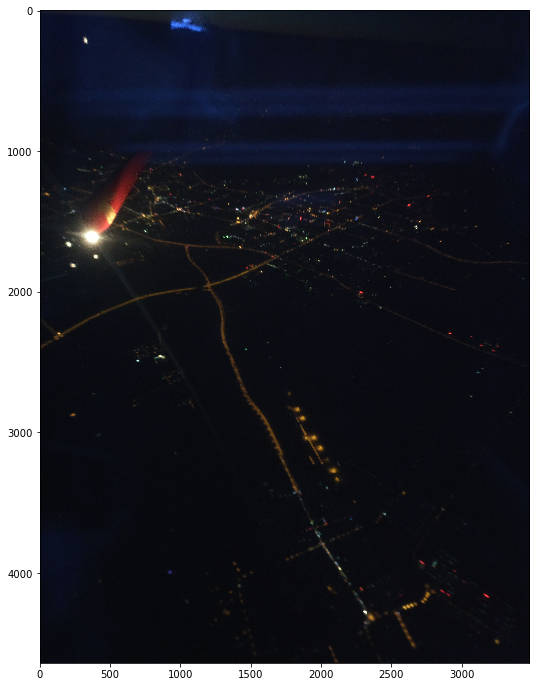

In [2]:
im_obj = Image.open('night.jpg')
plt.imshow(im_obj)

## Task 2: Blur and Zoom out

+ Gaussian Blur: `skimage.filters.gaussian_filter`
+ Zoom out: `skimage.transform.rescale`

### $(1)\ \ Blur \Rightarrow Zoom$  

In [3]:
# Define a helper function.
def easy_show(im, index, title=None):
    plt.subplot(index)
    plt.imshow(im)
    if len(im.shape) == 2:  # gray image
        plt.imshow(im, cmap='gray')
    if title:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])

In [4]:
from skimage.filters import gaussian
from skimage.transform import rescale

im = np.array(im_obj)

# Apply Gaussian blur.
sigma_set = [1, 3, 5, 10]
im_sig = [gaussian(im, sigma=sig, multichannel=True) for sig in sigma_set]
# Resize images.
im_srk = [rescale(item, 0.5) for item in im_sig]

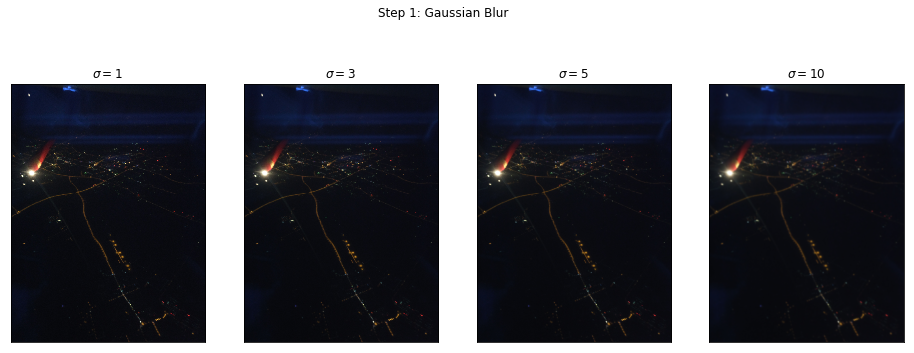

In [5]:
plt.figure(figsize=(16, 6))
for i in range(len(sigma_set)):
    easy_show(im_sig[i], 141 + i, '$\sigma = %d$' % sigma_set[i])
plt.suptitle('Step 1: Gaussian Blur')

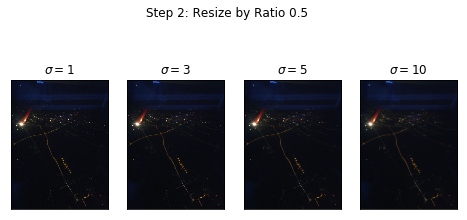

In [6]:
plt.figure(figsize=(8, 4))
for i in range(len(sigma_set)):
    easy_show(im_srk[i], 141 + i, '$\sigma = %d$' % sigma_set[i])
plt.suptitle('Step 2: Resize by Ratio 0.5')

### $(2)\ \ Zoom \Rightarrow Blur$  

In [7]:
# Resize images.
im_srk = rescale(im, 0.5) 
# Apply Gaussian blur.
sigma_set = [1, 3, 5, 10]
shrink_sig = [gaussian(im_srk, sigma=sig, multichannel=True) for sig in sigma_set]

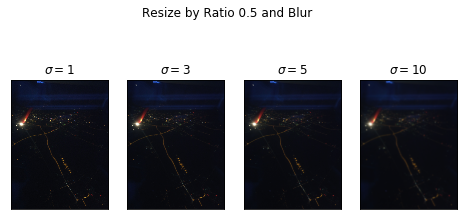

In [8]:
plt.figure(figsize=(8, 4))
for i in range(len(sigma_set)):
    easy_show(shrink_sig[i], 141 + i, '$\sigma = %d$' % sigma_set[i])
plt.suptitle('Resize by Ratio 0.5 and Blur')

### Discussion

+ Small images are more sensitive to *blur* operation.
+ Downsampel will balance some deterioration in *smoothing* noise.

## Task 3: Global Equalization[[1]](http://en.wikipedia.org/wiki/Histogram_equalization) v.s. Local Equalization[[2]](http://en.wikipedia.org/wiki/Adaptive_histogram_equalization)

[1] http://en.wikipedia.org/wiki/Histogram_equalization

[2] http://en.wikipedia.org/wiki/Adaptive_histogram_equalization

In [9]:
plt.rcParams['font.size'] = 9

# hist contains histogram and cumulative histogram.
def plot_img_and_hist(im, axes, bins=256):
    
    ax_im, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    
    # Display image.
    ax_im.imshow(im)
    ax_im.set_axis_off()
    
    # Display histogram.
    ax_hist.hist(im.ravel() * 255, bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    
    # -----------------------------------------------------------------------
    # xmin, xmax = dtype_range[im.dtype.type]
    # ax_hist.set_xlim(xmin, xmax)
    # -----------------------------------------------------------------------
    
    ax_hist.set_xlim(0, 255)
    # -----------------------------------------------------------------------
    
    # Display cumulative distribution.
    im_cdf, bins = exposure.cumulative_distribution(im, bins)
    if max(bins) < 1:
        bins *= 255
    ax_cdf.plot(bins, im_cdf, 'r')

    return ax_im, ax_hist, ax_cdf

+ `Axes.twinx()` generates axes that share a `x` axis but have different scales.  

+ `scilimits`  
    + $(m, n)$ pair of integers
    + If style is ‘sci’, scientific notation will be used for numbers outside the range $(10^m, 10^n)$.
    + Use $(0,0)$ to include all numbers.

In [10]:
from skimage import exposure
from skimage import img_as_float

# Global equalize
eq_hist = exposure.equalize_hist(im)

# Adaptive Equalization
eq_adap = exposure.equalize_adapthist(im, clip_limit=0.03)

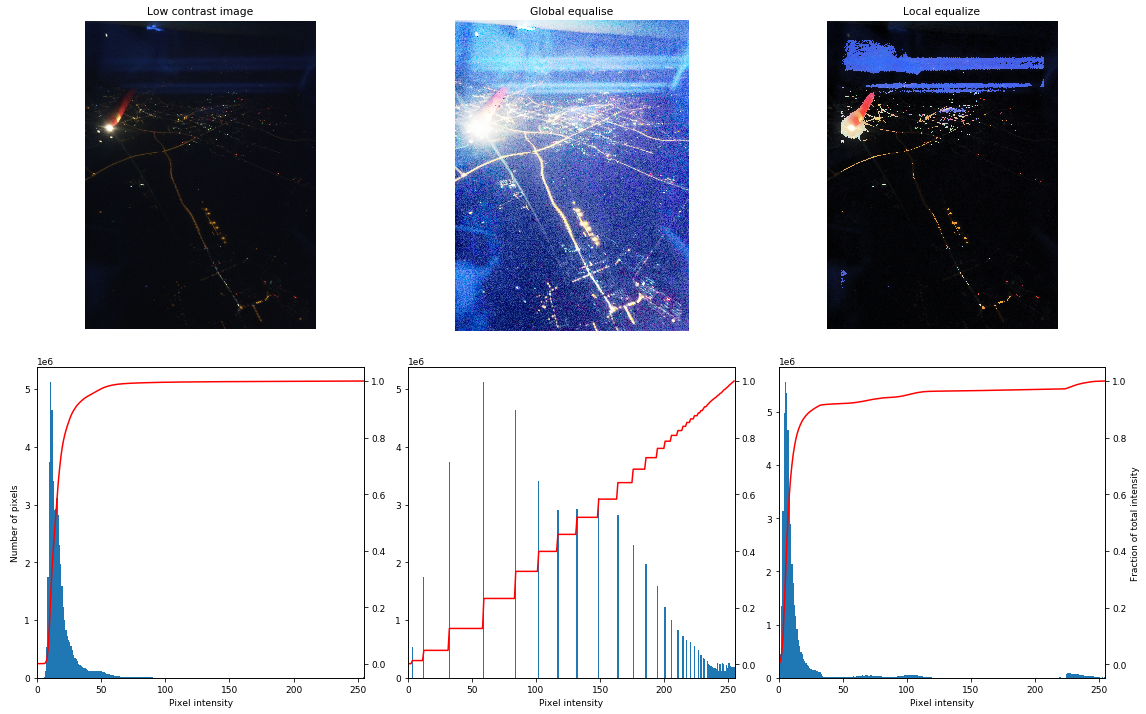

In [11]:
# Display results
fig = plt.figure(figsize=(16, 10))
axes = np.zeros((2, 3), dtype=np.object)

# -----------------------------------------------------------------------
# axes[0, 0] = plt.subplot(2, 3, 1)
# axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
# axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
# axes[1, 0] = plt.subplot(2, 3, 4)
# axes[1, 1] = plt.subplot(2, 3, 5)
# axes[1, 2] = plt.subplot(2, 3, 6)
# -----------------------------------------------------------------------

for i in range(2):
    for j in range(3):
        if i == 0 and j in (2, 3):
            axes[i, j] = plt.subplot(2, 3, i * 3 + j + 1, 
                                     sharex=axes[0, 0], sharey=axes[0, 0])
        else:
            axes[i, j] = plt.subplot(2, 3, i * 3 + j + 1)
# -----------------------------------------------------------------------
            
ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_as_float(im), axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(eq_hist, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(eq_adap, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()


## Task 4: Image Gradient

In [12]:
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.filters.rank import gradient
plt.rcParams['figure.figsize'] = (12, 9)

# Compute gradient.
im_gray = rgb2gray(im)
im_grad = gradient(im_gray, disk(5))

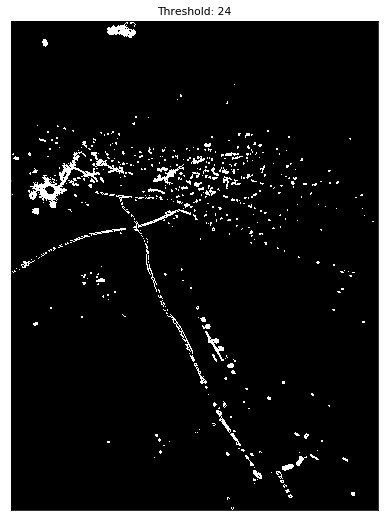

In [13]:
bw = im_grad > 24
easy_show(bw, 111, 'Threshold: 24')

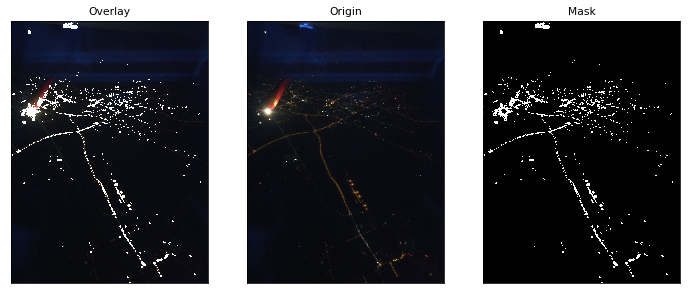

In [14]:
# Overlay original image.
im_ol = im.copy()
im_ol[np.where(bw)] = 255

easy_show(im_ol, 131, 'Overlay')
easy_show(im, 132, 'Origin')
easy_show(bw, 133, 'Mask')

## Task 5: Filters

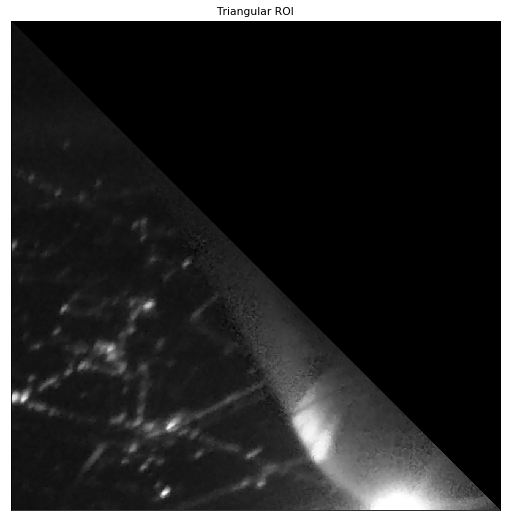

In [15]:
# Choose a triangular region

rec = np.fliplr(rgb2gray(im[800: 1600, 200: 1000, :]))

upper_triangle_index = np.triu_indices(800)
rec[upper_triangle_index] = 0

easy_show(rec, 111, 'Triangular ROI')

In [16]:
from skimage.filters.rank import mean
from skimage.filters.rank import median

def show_comparison(rec):
    # Mean
    easy_show(mean(rec, disk(3)), 231, '$Mean\ Filter\ r=3$')
    easy_show(mean(rec, disk(5)), 232, '$Mean\ Filter\ r=5$')
    easy_show(mean(rec, disk(7)), 233, '$Mean\ Filter\ r=7$')

    # Median
    easy_show(median(rec, disk(3)), 234, '$Median\ Filter\ r=3$')
    easy_show(median(rec, disk(5)), 235, '$Median\ Filter\ r=5$')
    easy_show(median(rec, disk(7)), 236, '$Median\ Filter\ r=7$')

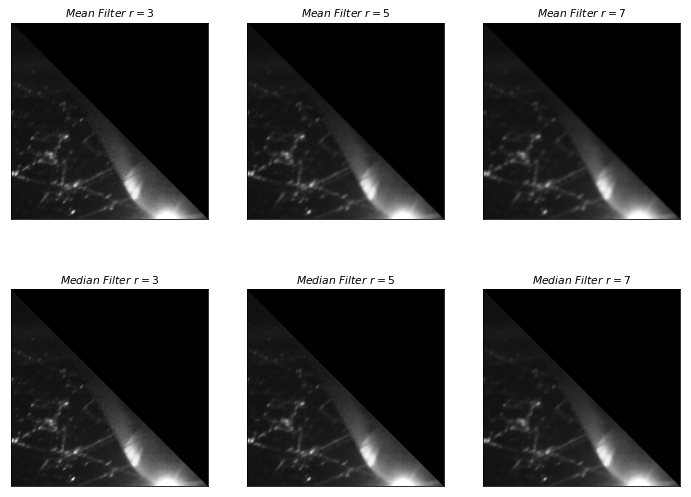

In [17]:
show_comparison(rec)

### Problem
This image taken on the plane is **blurry** itself.  
Load another image to compare `mean` and `median` filter.

In [19]:
from skimage.transform import resize

im_obj = Image.open('fish.jpg')
im = np.array(im_obj)

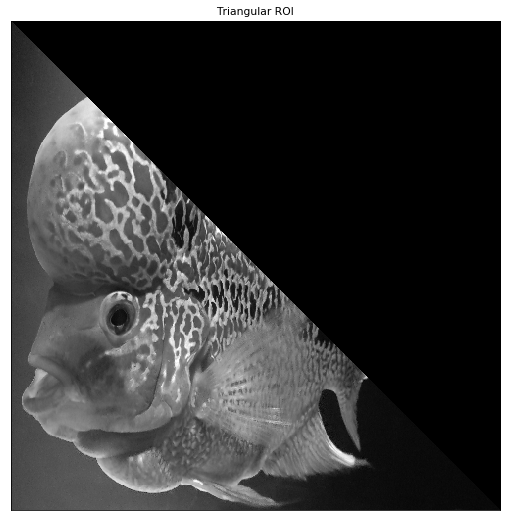

In [20]:
rec_temp = rgb2gray(im)
rec = resize(rec_temp, [500, 500])
upper_triangle_index = np.triu_indices(500)
rec[upper_triangle_index] = 0

easy_show(rec, 111, 'Triangular ROI')

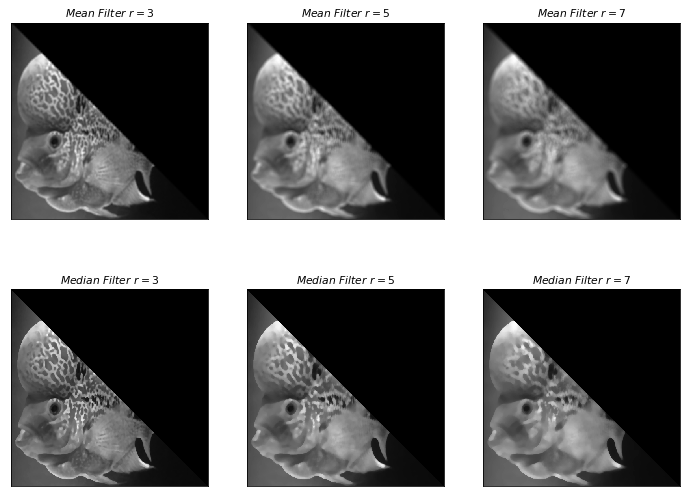

In [21]:
show_comparison(rec)

### Discussion

+ In this example, *Mean* filter blurs heavily than *Median* filter.
+ But the final effect depends on the data (surrounding pixels), and empirical experience. 